# import modules

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal
from eofs.standard import Eof

# load monthly gridded SST data 

In [2]:
ds=xr.open_dataset('cosine-weight/ERSST_monthly_1990_2021_2degree_global.nc')  # give the data path
sst=ds.sst

In [3]:
sst.attrs

{'long_name': 'Monthly Means of Sea Surface Temperature',
 'units': 'degC',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Mean',
 'dataset': 'NOAA Extended Reconstructed SST V5',
 'parent_stat': 'Individual Values',
 'actual_range': array([-1.8    , 42.32636], dtype=float32)}

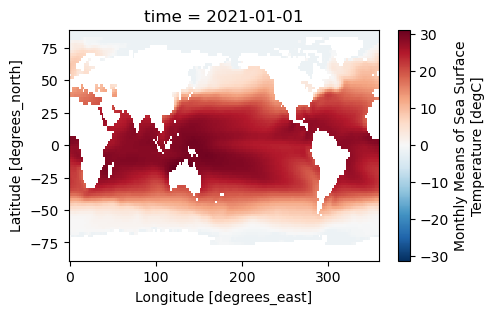

In [4]:
plt.figure(figsize=(5,3))
sst[-1].plot()

 plot of SST time series at a random location

/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


Text(16.22222222222222, 0.5, 'SST (°C)')

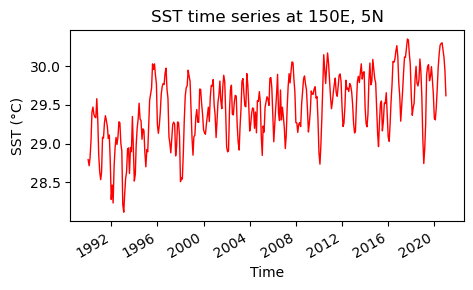

In [87]:
plt.figure(figsize=(5,3))
sst.sel(lat=5,lon=150,method='nearest').plot(color='r',lw=1)
plt.tight_layout()
plt.title('SST time series at 150E, 5N')
plt.ylabel('SST (°C)')

We dont want the season features  or long term changes in the data
# Data should be detrend and deseasoned before EOF analysis 

## Detrend the data

In [20]:
sst.coords

Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2021-01-01
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0

# Details of  function for detrending in python using scipy
 https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html

In [54]:
from scipy.signal import detrend

# NaN values in SST data cause an error in the detrend function. To temporarily address this issue, 
# I am creating a new variable 'filled_data' from SST with all NaN values filled with 0."
filled_data = sst.fillna(0)

detrended_filled_data = xr.apply_ufunc(detrend, filled_data, kwargs={'axis': 0}) #apply function , axis=0 ==> time axis

# Restore NaN values in the detrended data 
sst_detrend = detrended_filled_data.where(~np.isnan(sst), np.nan)

Lets verify

/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future 

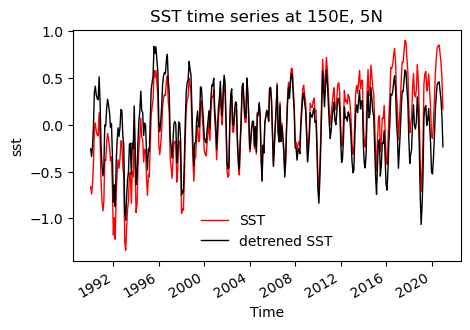

In [85]:
plt.figure(figsize=(5,3))

(sst.sel(lat=5,lon=150,method='nearest')-sst.sel(lat=5,lon=150,method='nearest').mean()).plot(color='r',label='SST',lw=1)
sst_detrend.sel(lat=5,lon=150,method='nearest').plot(color='k',label='detrened SST',lw=1)

plt.title('SST time series at 150E, 5N')
plt.legend(frameon=False)

# Remove seasonality of detrended SST data and make SST anomalies for each grid


In [64]:
sst_clim=sst_detrend.groupby('time.month').mean() # find the monthly climatology for each grid
ssta=sst_detrend.groupby('time.month')-sst_clim # remove monthly climatology from each grid

/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/sreerajp/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future 

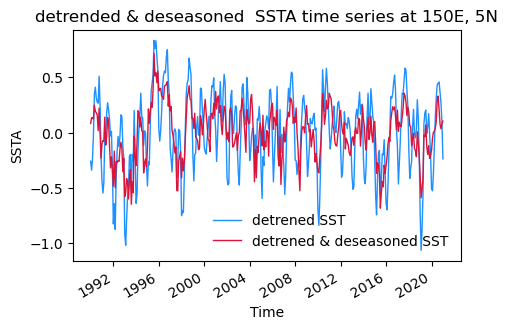

In [103]:
plt.figure(figsize=(5,3))

sst_detrend.sel(lat=5,lon=150,method='nearest').plot(color='dodgerblue', label='detrened SST',lw=1)
ssta.sel(lat=5,lon=150,method='nearest').plot(color='crimson',label='detrened & deseasoned SST',lw=1)
plt.title('detrended & deseasoned  SSTA time series at 150E, 5N')
plt.ylabel('SSTA')
plt.legend(frameon=False)

# function to find EOF and PCs

In [91]:
# function to estimate EOF 
# input >> xarray variable (3D [time,lat,lon]) # detrended and deseasonized data will apply to this function.

def eof_fun(data):
    # 4. Carry out EOF analysis
    ## 4.1 Create an EOF solver to do the EOF analysis
    ## Cosine of latitude weights are applied before the computation of EOFs.

    wgts   = np.cos(np.deg2rad(data.lat.values))
    wgts   = wgts.reshape(len(wgts), 1)
    solver = Eof(data.values, weights=wgts)

    # Retrieve the leading EOFs
    #Expressed as the correlation between the leading PC time series and the input SSTA at each grid point, and the leading PC time series itself.
    eof1 = solver.eofs(neofs=10)
    pc1  = solver.pcs(npcs=10, pcscaling=0)
    varfrac = solver.varianceFraction()
    lambdas = solver.eigenvalues()
    return(eof1,pc1,varfrac,lambdas)

apply function to data

In [97]:
eof1,pc1,varfrac,lambdas=eof_fun(ssta)

plot the result

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


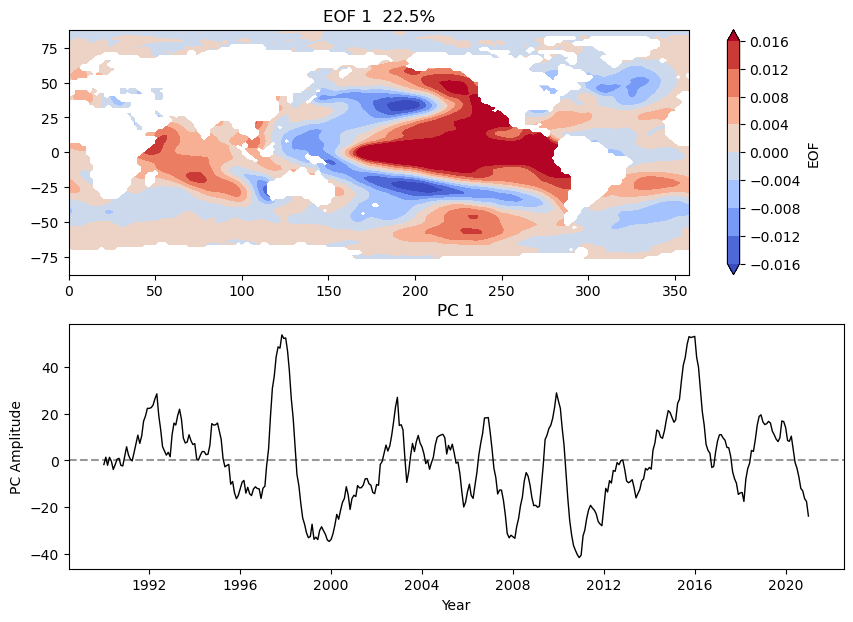

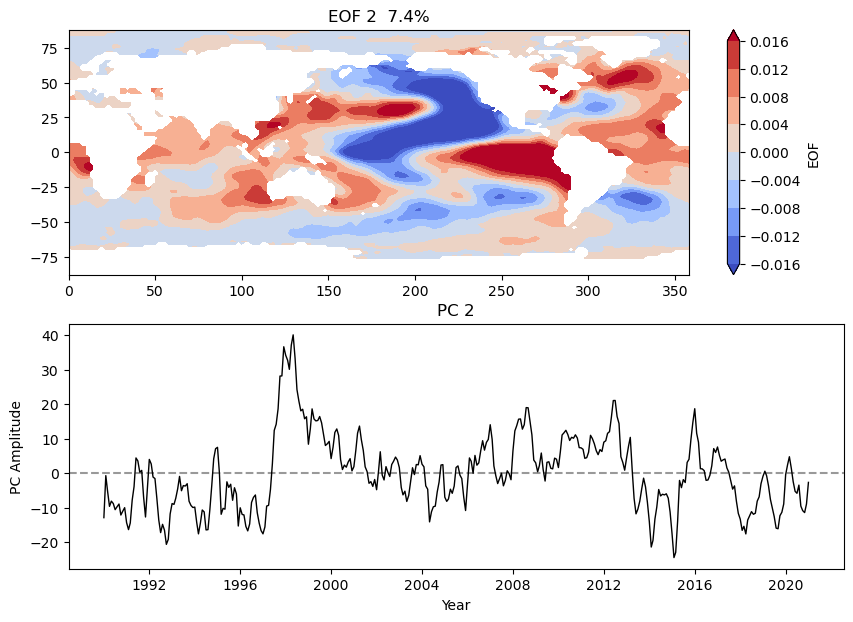

In [119]:
time_=ssta.time.values
lon_=ssta.lon
lat_=ssta.lat

# Tell the total number of modes you want to plot eg; 2 , 3 ,4 ..
nn=2

for i in range(0,nn):
    fig = plt.figure(figsize=(10,7))
    
    plt.subplot(211)
    plt.contourf(lon_, lat_, eof1[i,:,:].squeeze(),  cmap='coolwarm',levels=np.arange(-0.016,0.02,0.004),extend='both')
    plt.colorbar(label='EOF')
    plt.title('EOF '+str(i+1)+ '  ' +str((varfrac[i]*100).round(1))+'%')

    plt.subplot(212)
    plt.plot( time_,pc1[:,i], lw=1,color='k')
    plt.axhline(0, color='k',linestyle='--',alpha=0.4)
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude') 
    plt.title('PC '+str(i+1))

    
    plt.legend(frameon=False)

In [ ]:
#  spatial pattern of EOF1 is a El Nino pattern, and the associated time series shows large peaks and troughs for well-known El Nino and La Nina events.

# Check variances explained by leading EOFs


(6.294573410985419e-16, 0.23488337755203248)

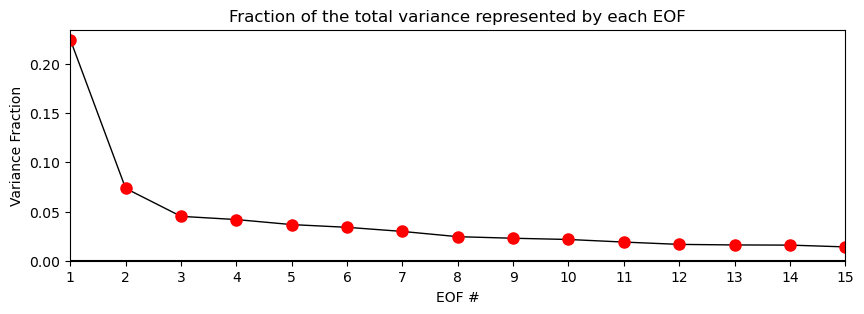

In [115]:
plt.figure(figsize=(10,3))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac[0:15], linewidth=1,color='k')
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)